## Import packages and initial DataFrame

In [47]:
import pandas as pds
import numpy as np
import textdistance
import statsmodels.api as sm
import scipy
import math
import tqdm
import os
import seaborn as sns
from random import choices
from matplotlib import pyplot as plt
import scipy.interpolate as interpolate

name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)
DF = DF.drop(['name', 'family_name'], axis=1)

## Generate covariates, treatment and associations with outcome

In [48]:
# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(0.1*DF.X1 -0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4 +0.5*DF.X5) )) # probability depending on covariates

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])
a = 5.5
b = 0.01
c = 0.08
d = 0.7

ate = a * 2.5
DF['Y'] = - 10 + a*DF['treatment']*DF['X2'] + b*np.exp(DF['X4']) + c*DF['X3']*DF['X1'] + d*DF['X5'] 

# generate new categorical variables for linkage
DF['id1'] = np.random.choice(np.arange(10), size = DF.shape[0]).astype(int)
DF['id2'] = np.random.choice(np.arange(15), size = DF.shape[0]).astype(int)
DF['id3'] = np.random.choice(np.arange(5), size = DF.shape[0]).astype(int)

## Linking variables i.e. identifiers are:
- sex
- country
- birth year
- id1
- id2
- id3

All categorical variables

In [49]:
identifiers = {'was_assigned_female':'strict','country':'strict','birth_year':'strict','id1':'strict','id2':'strict','id3':'strict'} # 'family_name':'jaro-winkler',
covariates = ['X1','X2','X3','X4','X5']

## Generate subdatasets A and B with common records

In [50]:
nbr_in_common = 100

common_records = DF.sample(n = nbr_in_common)

ate_common_records = a * common_records['X2'].mean()

B = pds.concat([DF.sample(n = 250), common_records]).drop(['Y'], axis = 1)
B = B.reset_index(drop=True)

A = pds.concat([DF.sample(n = 430), common_records])[list(identifiers.keys())+['Y']]
A = A.reset_index(drop=True)

# delete some data --> typos
B.loc[np.random.choice(np.arange(B.shape[0]), size=5), 'id1'] = ''
A.loc[np.random.choice(np.arange(A.shape[0]), size=5), 'id3'] = ''
B.loc[np.random.choice(np.arange(B.shape[0]), size=5), 'id2'] = ''

In [51]:
common_records.head()

,country,birth_year,was_assigned_female,X1,X2,X3,X4,X5,treatment,Y,id1,id2,id3
1795,IT,1948,1,72,3.177159,-0.818075,2.224003,2.453656,0,-12.902109,2,5,3
3962,GB,2013,0,7,1.506499,-0.565477,-0.681568,0.377132,0,-10.047616,8,11,1
4181,GB,1982,0,38,1.090397,1.220375,-0.238510,0.492446,0,-5.937470,5,7,3
3686,ES,1981,1,39,2.431990,1.000284,0.457619,0.468312,0,-6.535492,1,11,0
411,FR,1978,1,42,1.280858,-0.206429,1.727054,0.259254,0,-10.455884,6,13,4


In [52]:
A.head()

,was_assigned_female,country,birth_year,id1,id2,id3,Y
0,1,GB,1999,3,4,4,-6.867371
1,1,DE,1959,3,2,4,-10.217007
2,0,FI,1998,5,5,3,-8.579716
3,0,RU,1961,3,3,3,-11.672750
4,0,RU,1955,9,13,0,-3.984979


In [53]:
B.head()

,country,birth_year,was_assigned_female,X1,X2,X3,X4,X5,treatment,id1,id2,id3
0,GB,2013,1,7,2.057615,-0.231311,0.041530,0.982066,0,2,10,3
1,AL,2013,0,7,2.274997,1.386195,0.970874,1.047537,0,0,6,1
2,ES,1954,0,66,0.053781,0.293057,-0.771287,-0.374831,0,5,14,0
3,DE,2003,1,17,2.826893,0.305972,-0.473469,0.026250,0,0,13,0
4,FR,1962,1,58,2.898021,0.022942,-1.706936,-1.480495,0,7,2,2


## Write fucntions to compare linking variables among records
- Levenshtein similarity
- Jaro Winkler similarity
- Strict equality
- Large equality

In [54]:
def levenshtein_similarity(a,b):

    """ Check that levenshtein similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if 1 - textdistance.levenshtein(a, b)/max(len(a),len(b)) >= 0.95:
        return 1
    else:
        return 0

def jaro_winkler_similarity(a,b):

    """ Check that jaro-winkler similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if textdistance.jaro_winkler(a,b) >= 0.99:
        return 1
    else:
        return 0

def strict_equality(a,b):

    """ Check that a and b values are equal.
        
        a: any value,
        b: any value """

    return a==b

def large_equality(a,b):

    """ Check that years a and b expressed with four numbers are within the same decade.
        
        a: year,
        b: year """

    return str(a)[:-1]==str(b)[:-1]

## Write fucntions to compute the propensity score estimates based on covariates in a DataFrame

In [55]:
def logit(p):
    return np.log(p/(1-p))

def minmaxscaler(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    
def propensity_score(DF, covariates, scaler, convert_to_logit):
    
    """ Compute propensity score estimates: the probability (logistic regression) that an observation is treated or not conditioned on some covariates.
        These estimates are built conditionaly on covariates passed using a logit after transformation by scaler (when one is specified).
        Estimated probabilities can be converted into logit (convert_to_logit parameter).

        DF:                dataframe,
        covariates:        list of strings for covariates variable in DF,
        scaler:            sklearn.preprocessing function scaler for exemple,
        convert_to_logit:  boolean for converting probabilities to logit when building the propensity score estimates based on a logistic regression
    """
    exog = np.array(DF[covariates])
    if scaler != None:
        exog = scaler(exog)
    intercept = np.ones(DF.shape[0]).reshape(-1,1)
    exog = np.concatenate((exog, intercept), axis=1)
    model = sm.Logit(DF.treatment, exog).fit(disp=0)
    predictions = model.predict(exog)
    if convert_to_logit:
        return logit(predictions)
    else: 
        return predictions

def inverse_transform_sampling(data, n_bins):
    n_samples = 1
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)

In [56]:
B['propensity_score'] = propensity_score(B, covariates, None, False)

## Compute the cartesian product of all records in A and B
- add the source index (in A or B)
- add the linking score for each pair of records
- compute comparison vectors
- compute the probability of having same linking variables (at all and for matches)

In [57]:
AB = B.merge(A, how='cross', suffixes=("_B", "_A")) # preserve order of left keys: B file
AB["source_index_B"] = np.repeat(B.index, A.shape[0])
AB["source_index_A"] = np.tile(A.index, B.shape[0])

methods = {'jaro-winkler':jaro_winkler_similarity, 'levenshtein':levenshtein_similarity, 'strict':strict_equality, 'large':large_equality}

for linking_var in identifiers.keys():
    method = methods[identifiers[linking_var]]
    df = AB.filter(regex=linking_var)
    AB[linking_var+"_comparison"] = np.array([method(a, b) for a,b in zip(df.iloc[:,0], df.iloc[:,1])]).astype(int).reshape(-1,1)

comparison_vectors_only = AB.filter(regex="comparison")

AB

,country_B,birth_year_B,was_assigned_female_B,X1,X2,X3,X4,X5,treatment,id1_B,...,id3_A,Y,source_index_B,source_index_A,was_assigned_female_comparison,country_comparison,birth_year_comparison,id1_comparison,id2_comparison,id3_comparison
0,GB,2013,1,7,2.057615,-0.231311,0.041530,0.982066,0,2,...,4,-6.867371,0,0,1,1,0,0,0,0
1,GB,2013,1,7,2.057615,-0.231311,0.041530,0.982066,0,2,...,4,-10.217007,0,1,1,0,0,0,0,0
2,GB,2013,1,7,2.057615,-0.231311,0.041530,0.982066,0,2,...,3,-8.579716,0,2,0,0,0,0,0,1
3,GB,2013,1,7,2.057615,-0.231311,0.041530,0.982066,0,2,...,3,-11.672750,0,3,0,0,0,0,0,1
4,GB,2013,1,7,2.057615,-0.231311,0.041530,0.982066,0,2,...,0,-3.984979,0,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185495,IT,2013,1,7,0.706188,-1.138706,1.456084,-0.252071,0,8,...,2,-11.445422,349,525,0,0,0,0,0,0
185496,IT,2013,1,7,0.706188,-1.138706,1.456084,-0.252071,0,8,...,0,-4.316609,349,526,1,0,0,0,0,0
185497,IT,2013,1,7,0.706188,-1.138706,1.456084,-0.252071,0,8,...,1,-9.204522,349,527,0,0,0,0,0,0
185498,IT,2013,1,7,0.706188,-1.138706,1.456084,-0.252071,0,8,...,2,-8.506606,349,528,0,0,0,0,0,0


## Build the initial linkage
- find perfect comparisons between linking variables
- remove duplicates coming from A or from B
- on linked records, compute the propensity score
- build z0 the initial linkage estimates
- compute the true linkage (based on the common records subdataset built at the start)

For each record in $B$ we find the best match in $A$

Produce the linkage variable $$z_j = \left\{
    \begin{array}{ll}
        i & \text{if } \{i,j\} \text{ are matched} \\
        j + n_A & \text{otherwise.}
    \end{array}
\right.$$

In [58]:
where_good_comparisons = AB[comparison_vectors_only[['was_assigned_female_comparison', 'country_comparison', 'birth_year_comparison', 'id1_comparison', 'id2_comparison', 'id3_comparison']].all(axis=1)] # 'family_name_comparison', 

# remove duplicata: 
where_good_comparisons = where_good_comparisons[ (~where_good_comparisons.source_index_A.duplicated(keep=False)) & (~where_good_comparisons.source_index_B.duplicated(keep=False)) ]

idx_A = where_good_comparisons.source_index_A
idx_B = where_good_comparisons.source_index_B

z_init = -np.ones(B.shape[0])
z_init[idx_B] = idx_A

true_linkage_z = -np.ones(B.shape[0])
true_linkage_z[B.iloc[-nbr_in_common:,:].index] = A.iloc[-nbr_in_common:,:].index

Because the linkage estimate is built by removing duplicates from A and B to enforce 1-2-1 matching we miss some matches and make some errors. We evaluate the proportion of good estimations below:

In [59]:
(z_init == true_linkage_z).sum() / len(true_linkage_z)

0.8885714285714286

In [60]:
intercept = np.ones(AB.shape[0])
records_treatment =  np.array(AB.treatment)
records_propensity_score = np.array(AB.propensity_score)
interaction_term = records_treatment * records_propensity_score
records_covariates = np.array(AB[covariates])
XX = np.concatenate([intercept.reshape(-1,1), records_covariates, records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)

records_treatment_miss =  1 - np.array(AB.treatment)
interaction_term_miss = records_treatment_miss * records_propensity_score
XX_miss = np.concatenate([intercept.reshape(-1,1), records_covariates, records_propensity_score.reshape(-1,1), interaction_term_miss.reshape(-1,1)], axis=1)

## Remarks

- Launch the algorithm with a different initial linkage variable $z$
    - with a stupid $z$ (almost all records non linked: set to -1, and the first 10 records linked with the other first 10 records)
    - with a smart $z$ (80% of the values correspond to the true linkage variable, values might be link or no link)

    $\to$ the algorithm returns similar results


- Check the 5 best matches (best match meaning high probability to be chosen) comparison vectors

    $\to$ comparison vectors for possible matches are consistent (intervene in $w_1$, seems that given similar comparison vectors for probable matches, a high weight is attributed to the one that differs?)


- Check the 5 best matches propensity score

    $\to$ for one record in $B$ we have a propensity score, therefore possibles matches for the record in $B$ have the same propensity score
    $\to$ distribution of linked outcomes is based on:
    - $\varepsilon = Y - X \beta$ 
    - $Y$ from the cartesian product (outcomes from $A$ that are duplicate because of the need to match shape with $X$)
    - $X$ from the cartesian product (propensity score and treatment from $B$ that are duplicate because of the need to match shape with $Y$)
    - $\beta$ computed on previously linked data
        
    $\to$ distribution of non linked outcomes is based on:
    - (normal distr.) parameters computed on previously non linked data (including all possible pairs of records minus the ones decided to be matches)
    - $Y$ from the cartesian product (outcomes from $A$ that are duplicate because of the need to match both distributions for linked and non linked outcomes)


- Change priors ($\alpha_{\pi}, \beta_{\pi}$)

    $\mathbb P (unmatch) = (n_A - \#match) \times (n_B - \#match - 1 + \beta_{\pi}) / (\#match + \alpha_{\pi})$
    $\to$ to enforce the algorithm not to match everything we can:
    - increase $\beta_{\pi}$
    - decrease $\alpha_{\pi}$
    Increasing $\beta_{\pi}$ for example changes the willingness of the algorithm to make links at each MCMC iteration but does not change the linkage in the end (which is computed on the matches having high probabilities over all iterations)


- Change initial coefficient for the outcome regression

    $\to$ I don t know the true coefficient because in reality the outcome model / response model is not build on the porpensity score

- Outcome regression idea: try the same regression for link and non link data but fit $\beta$ depending on link or non link status

    $\to$ on the cartesian product of $A$ and $B$ considering non linked data we can fir $\beta$ to apply the same response model than for linked data, however a few data are matched then (not enough to prevent perfect separation when computing propensity scores on links)

## New remarks

- not better when considering a "plausible" outcome model (~ nor not worse)
- not better when considering not only the 5 best probabilities (nor not worse)
- not better when enforcing the -1 (nor not worse)

In [61]:
cartesian_product_AB = AB.copy(())

new_z = -np.ones(B.shape[0])
new_z[::2] = np.arange(len(new_z[::2])) # 1 value over 2 is assigned to a record in A

comparison_vectors = comparison_vectors_only.copy()
covariates = covariates.copy()
n_A = A.shape[0]
n_B = B.shape[0]
X = XX.copy()
X_miss = XX_miss.copy()

idx_match_A = new_z[new_z>=0]
idx_match_B = np.nonzero(new_z>=0)[0]
links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])
dict_empirical_count_linkage = {pair:0 for pair in pairs}
dict_params = {"unmatch":[], "match":[], "sigma_square":[], "betas":[], "sigma2_square":[], "mu2":[], "atel":[]}

nbr_iter = 800

a_sigma, b_sigma, a_sigma2, b_sigma2, a, b, alpha_pi, beta_pi = 1, 1, 1, 1, 1, 1, 1, 1
Betas = scipy.stats.multivariate_normal.rvs(np.zeros(X.shape[1]), np.eye(X.shape[1]))
mu2 = scipy.stats.norm.rvs(0, 1)

approx_integral = 50
dev = 0.25 * np.std(cartesian_product_AB.Y)
low_val = int(np.min(cartesian_product_AB.Y) - dev)
high_val = int(np.max(cartesian_product_AB.Y) + dev)
nbr_pts = int(high_val - low_val)

for _ in tqdm.tqdm(range(nbr_iter)):

    ### --  UPDATE THETA --> match, unmatch
    comparison_vectors_for_non_matches = comparison_vectors[~pairs.isin(links)]
    unmatch = scipy.stats.beta.rvs(comparison_vectors_for_non_matches.sum(axis=0) + a, (1-comparison_vectors_for_non_matches).sum(axis=0) + b)
    comparison_vectors_for_matches = comparison_vectors[pairs.isin(links)]
    match = scipy.stats.beta.rvs(comparison_vectors_for_matches.sum(axis=0) + a, (1-comparison_vectors_for_matches).sum(axis=0) + b)
    dict_params["unmatch"].append(unmatch)
    dict_params["match"].append(match)

    ### --  UPDATE COEF OUTCOME MODEL (MATCHES AND NON MATCHES) --> Betas --> mu2, sigma2_square --> outcome model distribution
    data_for_matches = cartesian_product_AB[pairs.isin(links)]
    outcome_for_matches =  np.array(data_for_matches.Y)
    intercept = np.ones(len(outcome_for_matches))
    treatment_for_matches =  np.array(data_for_matches.treatment)
    linked_records_propensity_score = np.array(data_for_matches.propensity_score) # propensity_score(data_for_matches, covariates, None, False)
    interaction_term = treatment_for_matches * linked_records_propensity_score
    linked_records_covariates = np.array(data_for_matches[covariates])
    K = np.concatenate([intercept.reshape(-1,1), linked_records_covariates, linked_records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
    n_AB = sum(new_z>=0)
    sigma_square = scipy.stats.invgamma.rvs(a_sigma + n_AB/2, loc=0, scale=np.linalg.norm(outcome_for_matches - K @ np.array(Betas))**2 / 2 + b_sigma) #sigma_square = 1 / scipy.stats.gamma.rvs(a_sigma + n_AB/2, loc=0, scale=1/(np.linalg.norm(outcome_for_matches - K @ np.array(Betas))**2 / 2 + b_sigma))
    Sigma_beta = np.linalg.inv( (K.T @ K)/sigma_square + np.eye(K.shape[1]) )
    mu_beta = Sigma_beta @ (K.T @ outcome_for_matches)/sigma_square
    Betas = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta)
    residuals = cartesian_product_AB.Y - X @ Betas.T
    estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
    distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
    dict_params["sigma_square"].append(sigma_square)
    dict_params["betas"].append(Betas)

    data_for_non_matches = A[~A.index.isin(idx_match_A)]
    outcome_for_non_matches =  np.array(data_for_non_matches.Y)
    sigma2_square = scipy.stats.invgamma.rvs(a_sigma2 + (n_A - n_AB)/2, loc=0, scale=b_sigma2 + sum((outcome_for_non_matches - mu2)**2)/2) #sigma2_square = 1 / scipy.stats.gamma.rvs(a_sigma2 + (n_A - n_AB)/2, loc=0, scale=1/(b_sigma2 + sum((outcome_for_non_matches - mu2)**2)/2))
    sigma_mu2_square = 1 / ((n_A - n_AB)/sigma2_square + 1)
    m_mu2 = sigma_mu2_square * ((outcome_for_non_matches).sum() / sigma2_square)
    mu2 = scipy.stats.norm.rvs(m_mu2, np.sqrt(sigma_mu2_square))
    distr_non_linked_outcomes = scipy.stats.norm.pdf(cartesian_product_AB.Y, mu2, np.sqrt(sigma2_square))
    dict_params["sigma2_square"].append(sigma2_square)
    dict_params["mu2"].append(mu2)
    
    ### --  UPDATE PROBABILITIES
    w1 = ( np.multiply( comparison_vectors, np.log(match/unmatch) ) + np.multiply( 1-comparison_vectors, np.log((1-match)/(1-unmatch)) ) ).sum(axis=1)
    w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)
    probabilities = np.array(np.exp(w1+w2))
    probabilities = probabilities.reshape(n_B, n_A)
    
    for j in range(n_B):
        n_AB_ = (np.delete(new_z, j)>=0).sum()
        proba_for_unmatch = (n_A - n_AB_) * (n_B - n_AB_ - 1 + beta_pi) / (n_AB_ + alpha_pi)
        not_possible_values = list( set(np.delete(new_z, j).astype(int)) - set([-1]) )
        proba = probabilities[j,:].copy()
        proba[not_possible_values]  = 0
        proba = np.append(proba, proba_for_unmatch)
        possible_values = np.arange(n_A)
        possible_values = np.append(possible_values, -1)
        val = choices(possible_values, weights = proba)[0]
        new_z[j] = val

    ### ATEL
    y_miss_new = np.random.uniform( low_val, high_val, size = (data_for_matches.shape[0], nbr_pts)) # generate a y_miss vector (of nbr_pts) for each individual
    X_miss_new = X_miss[pairs.isin(links)] # get 1 X vector for each individual 
    Betas_miss_new = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta, size=(nbr_pts, approx_integral)) # generate approx_integral Betas vectors for each point
    y_miss_new = np.repeat(y_miss_new[:, np.newaxis, :], approx_integral, axis=1)
    ITS = np.mean( y_miss_new - ( Betas_miss_new @ X_miss_new.T ).T, axis = 1)
    missing_outcomes_new = np.array([ inverse_transform_sampling(ITS[indiv], len(ITS[indiv])) for indiv in range(ITS.shape[0]) ])
    new_Y0 = (data_for_matches.treatment==0) * data_for_matches.Y + (data_for_matches.treatment==1) * missing_outcomes_new.flatten()
    new_Y1 = (data_for_matches.treatment==1) * data_for_matches.Y + (data_for_matches.treatment==0) * missing_outcomes_new.flatten()
    new_atel = np.mean(new_Y1 - new_Y0)
    dict_params["atel"].append(new_atel)

    ### _ UPDATE INDICES FOR MATCHES
    idx_match_A = new_z[new_z>=0]
    idx_match_B = np.nonzero(new_z>=0)[0]
    links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))

    for link in links: # check burn-in
        dict_empirical_count_linkage[link] += 1

v = np.array(list(dict_empirical_count_linkage.values())) / nbr_iter
k = np.array(list(dict_empirical_count_linkage.keys()))

100%|██████████| 800/800 [01:52<00:00,  7.11it/s]


In [62]:
dict_params_legend = {
    "unmatch":identifiers.keys(), 
    "match":identifiers.keys(), 
    "sigma_square":[f"$\sigma^2$"], 
    "betas":[ r"$\beta_0$", r"$\beta_1$", r"$\beta_2$", r"$\beta_3$", r"$\beta_4$", r"$\beta_5$", r"$\beta_6$", r"$\beta_7$" ], 
    "sigma2_square":[r"$\sigma_2^2$"], 
    "mu2":[r"$\mu_2$"], 
    "atel":["atel"]}

dict_params_title = {
    "unmatch":"unmatch", 
    "match":"match", 
    "sigma_square":r"$\sigma^2$", 
    "betas":r"$\beta$",
    "sigma2_square":r"$\sigma_2^2$", 
    "mu2":r"$\mu_2$", 
    "atel":"atel"}

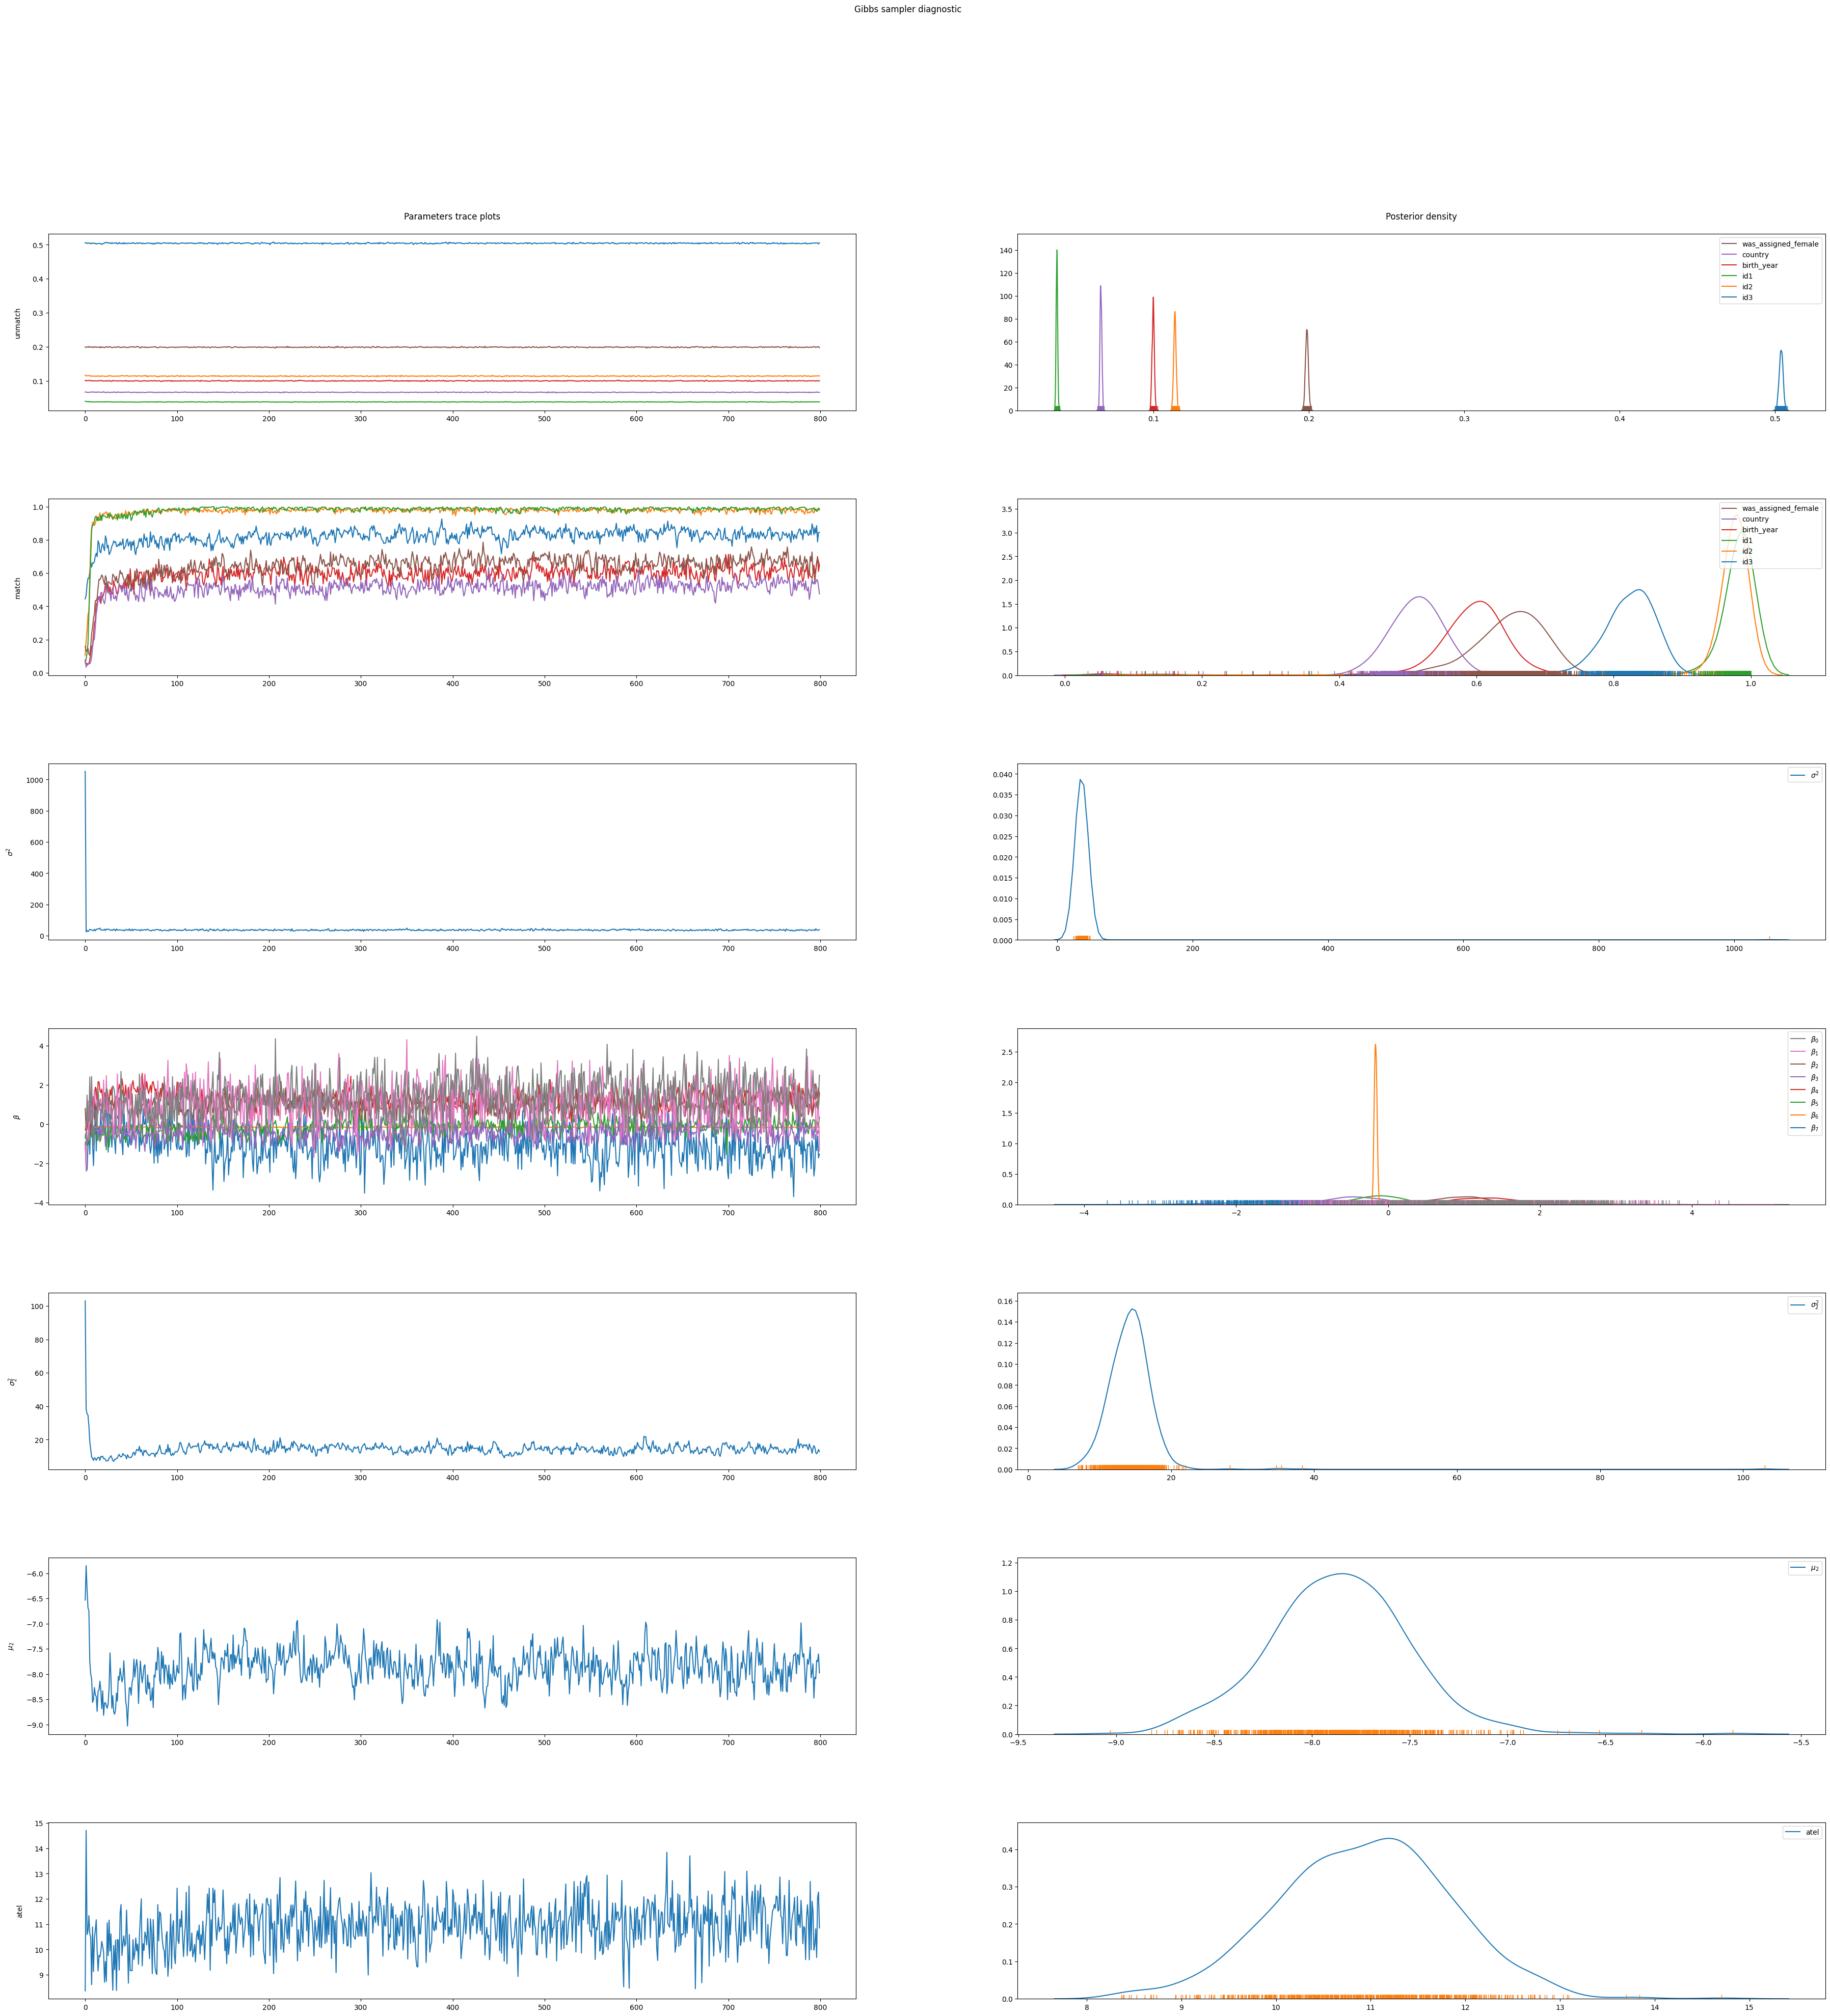

In [63]:
plt.figure(figsize = (45, 45))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Gibbs sampler diagnostic")
i=0
for n, param in enumerate(dict_params.keys()):
    i+=1
    ax1 = plt.subplot(7, 2, n + i) # row, column, number on which current drawing
    ax1.plot(dict_params[param])
    if n==0:
        ax1.set_title("Parameters trace plots\n")
    ax1.set_xlabel("")
    ax1.set_ylabel(f"{dict_params_title[param]}\n")

    j=i+1
    ax2 = plt.subplot(7, 2, n + j) 
    sns.kdeplot(data=np.array(dict_params[param]), ax=ax2, legend=None)
    sns.rugplot(data=np.array(dict_params[param]), ax=ax2, legend=None)
    if n==0:
        ax2.set_title("Posterior density\n")
    ax2.legend(dict_params_legend[param], loc='upper right')
    ax2.set_xlabel("")
    ax2.set_ylabel("")

plt.savefig(os.path.join('img', f"gibbs_sampler_diagnostic.pdf"), format="pdf", bbox_inches="tight")
plt.show()

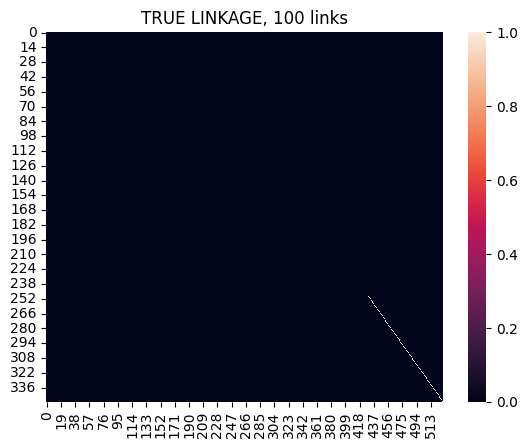

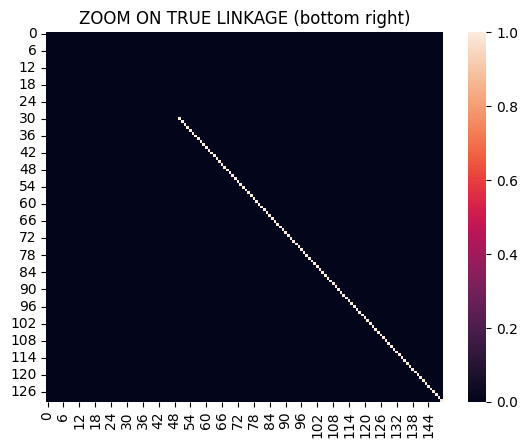

In [64]:
z_linkage_vector = true_linkage_z.copy()

idx_in_A_links = z_linkage_vector[z_linkage_vector>=0]
idx_in_B_links = np.nonzero(z_linkage_vector>=0)[0]
linkage_matrix = np.zeros((B.shape[0], A.shape[0]))

for link in range(len(idx_in_A_links)):
    linkage_matrix[int(idx_in_B_links[link]), int(idx_in_A_links[link])] = 1

sns.heatmap(linkage_matrix)
plt.title(f"TRUE LINKAGE, {(linkage_matrix==1).sum()} links")
plt.savefig(os.path.join('img', f"true_linkage_{(linkage_matrix==1).sum()}links.pdf"), format="pdf", bbox_inches="tight")
plt.show()

sns.heatmap(linkage_matrix[220:, 380:])
plt.title(f"ZOOM ON TRUE LINKAGE (bottom right)")
plt.savefig(os.path.join('img', f"zoom_true_linkage_(bottom-right).pdf"), format="pdf", bbox_inches="tight")
plt.show()

In [65]:
np.unique(v)[-5:]
# maybe get the 100 best links ?
# maybe previously choose only the links necessary for the overlap?
# ...?

array([0.99   , 0.99125, 0.9925 , 0.99375, 0.995  ])

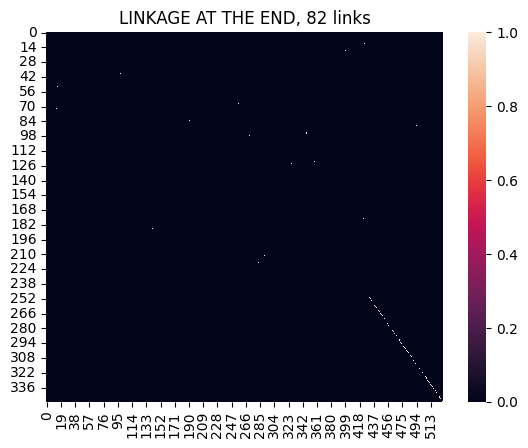

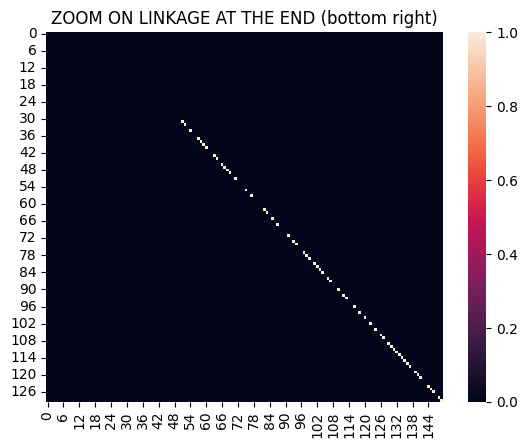

In [66]:
best = k[v>=0.9] # require to fix a number of link to make: k[np.argpartition(v, -100)[-100:]] # require to have high confidence enough for some links k[v>=0.9]
idx_A = best[:,0]
idx_B = best[:,1]

linkage_matrix = np.zeros((B.shape[0], A.shape[0]))

for link in range(len(idx_A)):
    A_idx = idx_A[link]
    B_idx = idx_B[link]
    linkage_matrix[B_idx, A_idx] = 1

sns.heatmap(linkage_matrix)
plt.title(f"LINKAGE AT THE END, {(linkage_matrix==1).sum()} links")
plt.savefig(os.path.join('img', f"linkage_at_end_{(linkage_matrix==1).sum()}links.pdf"), format="pdf", bbox_inches="tight")
plt.show()

sns.heatmap(linkage_matrix[220:, 380:])
plt.title(f"ZOOM ON LINKAGE AT THE END (bottom right)")
plt.savefig(os.path.join('img', f"linkage_at_end_(bottom-right).pdf"), format="pdf", bbox_inches="tight")
plt.show()

In [67]:
ate_common_records

13.810212163281498

In [68]:
links = pds.MultiIndex.from_tuples(zip(idx_A,idx_B))
data_for_matches = cartesian_product_AB[pairs.isin(links)]
    
### ATEL
y_miss_new = np.random.uniform( low_val, high_val, size = (data_for_matches.shape[0], nbr_pts)) # generate a y_miss vector (of nbr_pts) for each individual
X_miss_new = X_miss[pairs.isin(links)] # get 1 X vector for each individual 
Betas_miss_new = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta, size=(nbr_pts, approx_integral)) # generate approx_integral Betas vectors for each point
y_miss_new = np.repeat(y_miss_new[:, np.newaxis, :], approx_integral, axis=1)
ITS = np.mean( y_miss_new - ( Betas_miss_new @ X_miss_new.T ).T, axis = 1)
missing_outcomes_new = np.array([ inverse_transform_sampling(ITS[indiv], len(ITS[indiv])) for indiv in range(ITS.shape[0]) ])
new_Y0 = (data_for_matches.treatment==0) * data_for_matches.Y + (data_for_matches.treatment==1) * missing_outcomes_new.flatten()
new_Y1 = (data_for_matches.treatment==1) * data_for_matches.Y + (data_for_matches.treatment==0) * missing_outcomes_new.flatten()
new_atel = np.mean(new_Y1 - new_Y0)
new_atel

9.236383686133784

## Guha estimation of the Causal Effect

In [69]:
# idx_A, idx_B are the indices of linked records

N = 100

Betas = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta)
distr_outcomes = scipy.stats.multivariate_normal.pdf(Betas, mu_beta, Sigma_beta)
for _ in range(N):
    distr_outcomes += scipy.stats.multivariate_normal.pdf(Betas, mu_beta, Sigma_beta)

distr_outcomes /= N

In [70]:
# idx_A, idx_B are the indices of linked records

N = 100

Betas = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta, size=N) # with last parameters

Y_miss = 0
for i in range(N):
    residuals = linked_record_data.Y - X_miss @ Betas[i].T
    estimated_variance = residuals.T @ residuals / (len(residuals) - (X_miss.shape[1]+1))
    Y_miss += scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))

Y_miss /= N

Y_0 = (linked_record_data.treatment==0) * linked_record_data.Y + (linked_record_data.treatment==1) * Y_miss
Y_1 = (linked_record_data.treatment==1) * linked_record_data.Y + (linked_record_data.treatment==0) * Y_miss

np.mean( Y_1 - Y_0 )


NameError: name 'linked_record_data' is not defined

In [ ]:
ate_common_records # ate among the common records

13.374079695262996

In [ ]:
a = 5.5
b = 0.01
c = 0.08
d = 0.7

Y_miss = - 10 + a*(1-linked_record_data['treatment'])*linked_record_data['X2'] + b*np.exp(linked_record_data['X4']) + c*linked_record_data['X3']*linked_record_data['X1'] + d*linked_record_data['X5'] 

Y_0 = (linked_record_data.treatment==0) * linked_record_data.Y + (linked_record_data.treatment==1) * Y_miss
Y_1 = (linked_record_data.treatment==1) * linked_record_data.Y + (linked_record_data.treatment==0) * Y_miss

np.mean( Y_1 - Y_0 )

13.077902594668911